# Introduction
- nb20で出力した結果を解析してみる。
    - data: nb20_oof_lgb_-0.28471684197364716.csv 
- 気になる部分
    - `type`ごとに過学習してないか。
    - `null`の部分がネックになっていないか。

# Import everything I need :)

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

## set 

In [2]:
sns.set(style='darkgrid')
pd.set_option('display.max_columns', 100)

## load data

In [3]:
nb = 20
isSmallSet = False
step = 100

In [4]:
file_path = './input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['./input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 './input/champs-scalar-coupling/structures.csv',
 './input/champs-scalar-coupling/mulliken_charges.csv',
 './input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 './input/champs-scalar-coupling/train.csv',
 './input/champs-scalar-coupling/test.csv',
 './input/champs-scalar-coupling/sample_submission.csv',
 './input/champs-scalar-coupling/dipole_moments.csv',
 './input/champs-scalar-coupling/potential_energy.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [::step]
else:
    train = pd.read_csv(path)

In [6]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [7]:
# oof from nb20
path = './output/nb20_oof_lgb_-0.28471684197364716.csv'
if isSmallSet:
    oof = pd.read_csv(path)[::step]
else:
    oof = pd.read_csv(path)

In [8]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {oof.shape[0]} rows in oof data.')

There are 4658147 rows in train data.
There are 4658147 rows in oof data.


In [9]:
train['oof'] = oof

## Function

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is      : {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Create Features
- ここでは、nb16でわかったnullが多い特徴量のみ作成する
- list
    - molecule_atom_index_1_dist_std
    - molecule_type_dist_std_diff

**basic**

In [11]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

# test = map_atom_info(test, 0)
# test = map_atom_info(test, 1)

distances

In [12]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
# test_p_0 = test[['x_0', 'y_0', 'z_0']].values
# test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
# test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
# test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
# test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [13]:
def create_features(df):
#     df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
#     df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
#     df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
#     df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
#     df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
#     df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
#     df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
#     df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
#     df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
#     df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
#     df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
#     df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
#     df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
#     df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
#     df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
#     df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
#     df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
#     df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
#     df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
#     df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
#     df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
#     df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
#     df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
#     df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
#     df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
#     df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
#     df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
#     df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
#     df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
#     df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
#     df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
#     df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
#     df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
#     df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
#     df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
#     df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
#     df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
#     df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
#     df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
#     df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
#     df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
#     df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
#     df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
#     df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
#     df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
#     df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
#     df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
#     df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
#     df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    
    df = reduce_mem_usage(df)

    return df

In [14]:
%%time
train = create_features(train)

Memory usage of dataframe is      : 781.85 MB
Memory usage after optimization is: 220.82 MB
Decreased by 71.8%
CPU times: user 3.36 s, sys: 1.63 s, total: 4.99 s
Wall time: 4.99 s


# Analysis

## Basics

In [15]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,oof,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,molecule_atom_index_1_dist_std,molecule_type_dist_std
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,85.187500,H,0.00215,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797,0.000221,1.192383,0.000036,0.000003,0.000003
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,-10.054688,H,0.00215,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203,1.019531,2.160156,0.000003,NaN,0.000014


In [16]:
train.isnull().sum(axis=0)

id                                     0
molecule_name                          0
atom_index_0                           0
atom_index_1                           0
type                                   0
scalar_coupling_constant               0
oof                                    0
atom_0                                 0
x_0                                    0
y_0                                    0
z_0                                    0
atom_1                                 0
x_1                                    0
y_1                                    0
z_1                                    0
dist                                   0
dist_x                                 0
dist_y                                 0
dist_z                                 0
molecule_atom_index_1_dist_std    284076
molecule_type_dist_std             48394
dtype: int64

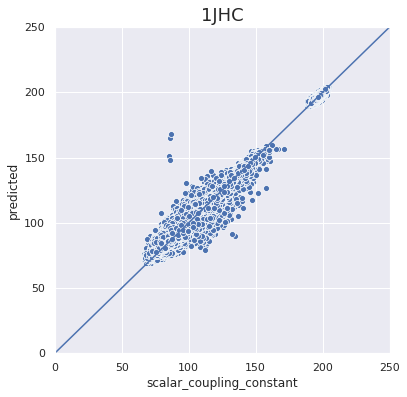

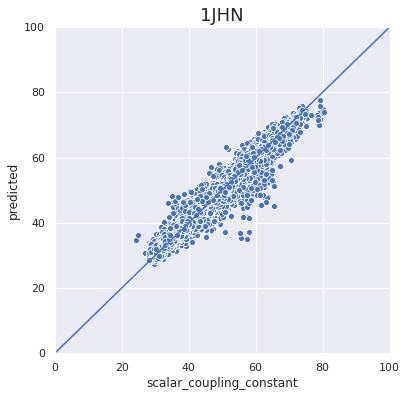

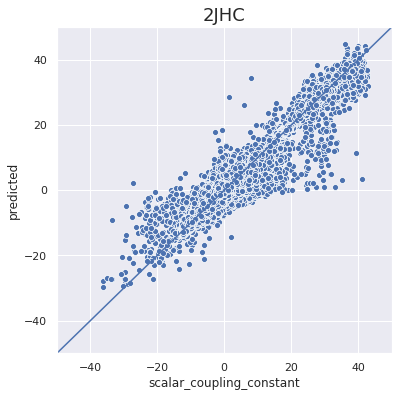

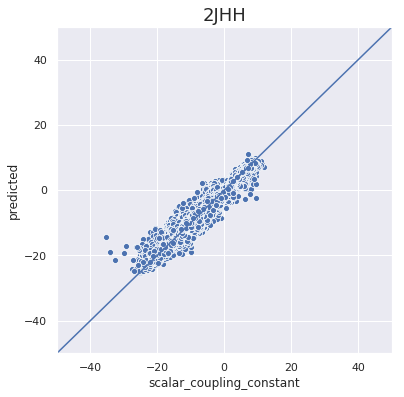

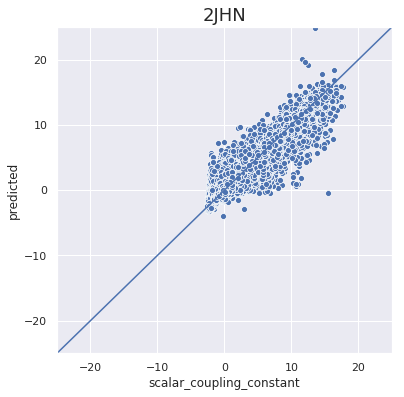

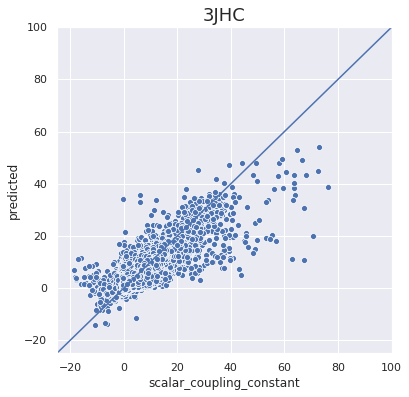

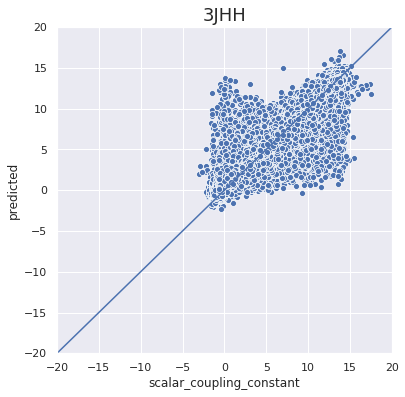

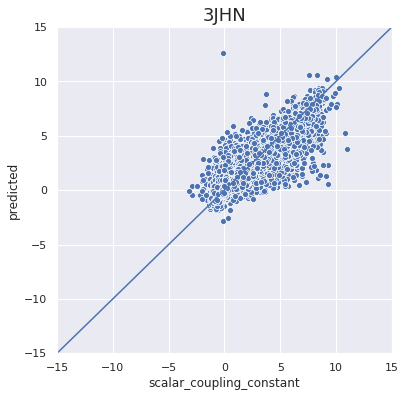

In [17]:
def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='oof',
                        data=train.loc[train['type']==ctype,
                        ['scalar_coupling_constant', 'oof']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)

---> 3JHC がなんか微妙な気がする

## focus on 3JHC 

In [62]:
def plot_oof_preds_null(ctype, cnull, llim, ulim):
        null_idx = train[cnull].isnull()
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='oof',
                        data=train.loc[train['type']==ctype,
                        ['scalar_coupling_constant', 'oof']]);
        plt.scatter(train.loc[train['type']==ctype, 'scalar_coupling_constant'][null_idx],
                    train.loc[train['type']==ctype, 'oof'][null_idx])
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}-{cnull}', fontsize=18)
        plt.show()

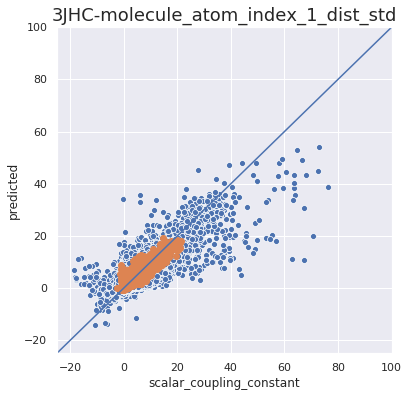

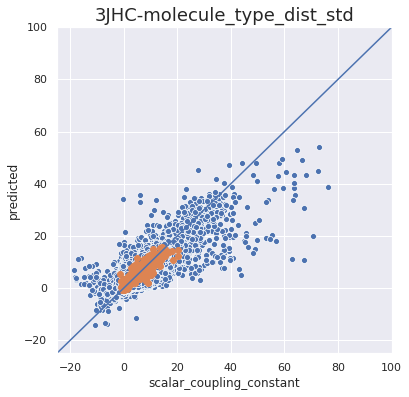

In [63]:
plot_oof_preds_null('3JHC', 'molecule_atom_index_1_dist_std', -25, 100)
plot_oof_preds_null('3JHC', 'molecule_type_dist_std', -25, 100)

---> null が悪さしてるわけじゃなさそう  
---> 次は、外れている値を確認する

---
**はずれ値**

In [83]:
# 3jHCのはずれ値のインデックス
y0   = train.loc[train['type']==ctype, 'scalar_coupling_constant']
yhat = train.loc[train['type']==ctype, 'oof']
error = np.abs(y0 - yhat)
error_idx = error > 20
del y0, yhat, error

In [81]:
def plot_oof_preds_out(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='oof',
                        data=train.loc[train['type']==ctype,
                        ['scalar_coupling_constant', 'oof']]);
        
        # compute error 
        y0   = train.loc[train['type']==ctype, 'scalar_coupling_constant']
        yhat = train.loc[train['type']==ctype, 'oof']
        error = np.abs(y0 - yhat)
        error_idx = error > 20
                       
        plt.scatter(train.loc[train['type']==ctype, 'scalar_coupling_constant'][error_idx],
                    train.loc[train['type']==ctype, 'oof'][error_idx])
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

n_out:  77


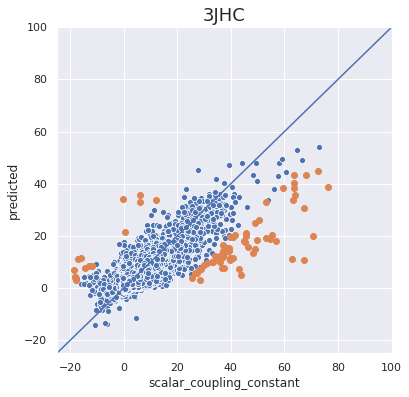

In [111]:
print('n_out: ', sum(error_idx))
plot_oof_preds_out('3JHC', -25, 100)

**はずれ値のインデックスに相当する特徴量を確認してみる**

In [84]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'oof', 'atom_0', 'x_0', 'y_0', 'z_0',
       'atom_1', 'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z',
       'molecule_atom_index_1_dist_std', 'molecule_type_dist_std'],
      dtype='object')

In [109]:
col_list = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1','dist',
       'molecule_atom_index_1_dist_std', 'molecule_type_dist_std', 'scalar_coupling_constant']

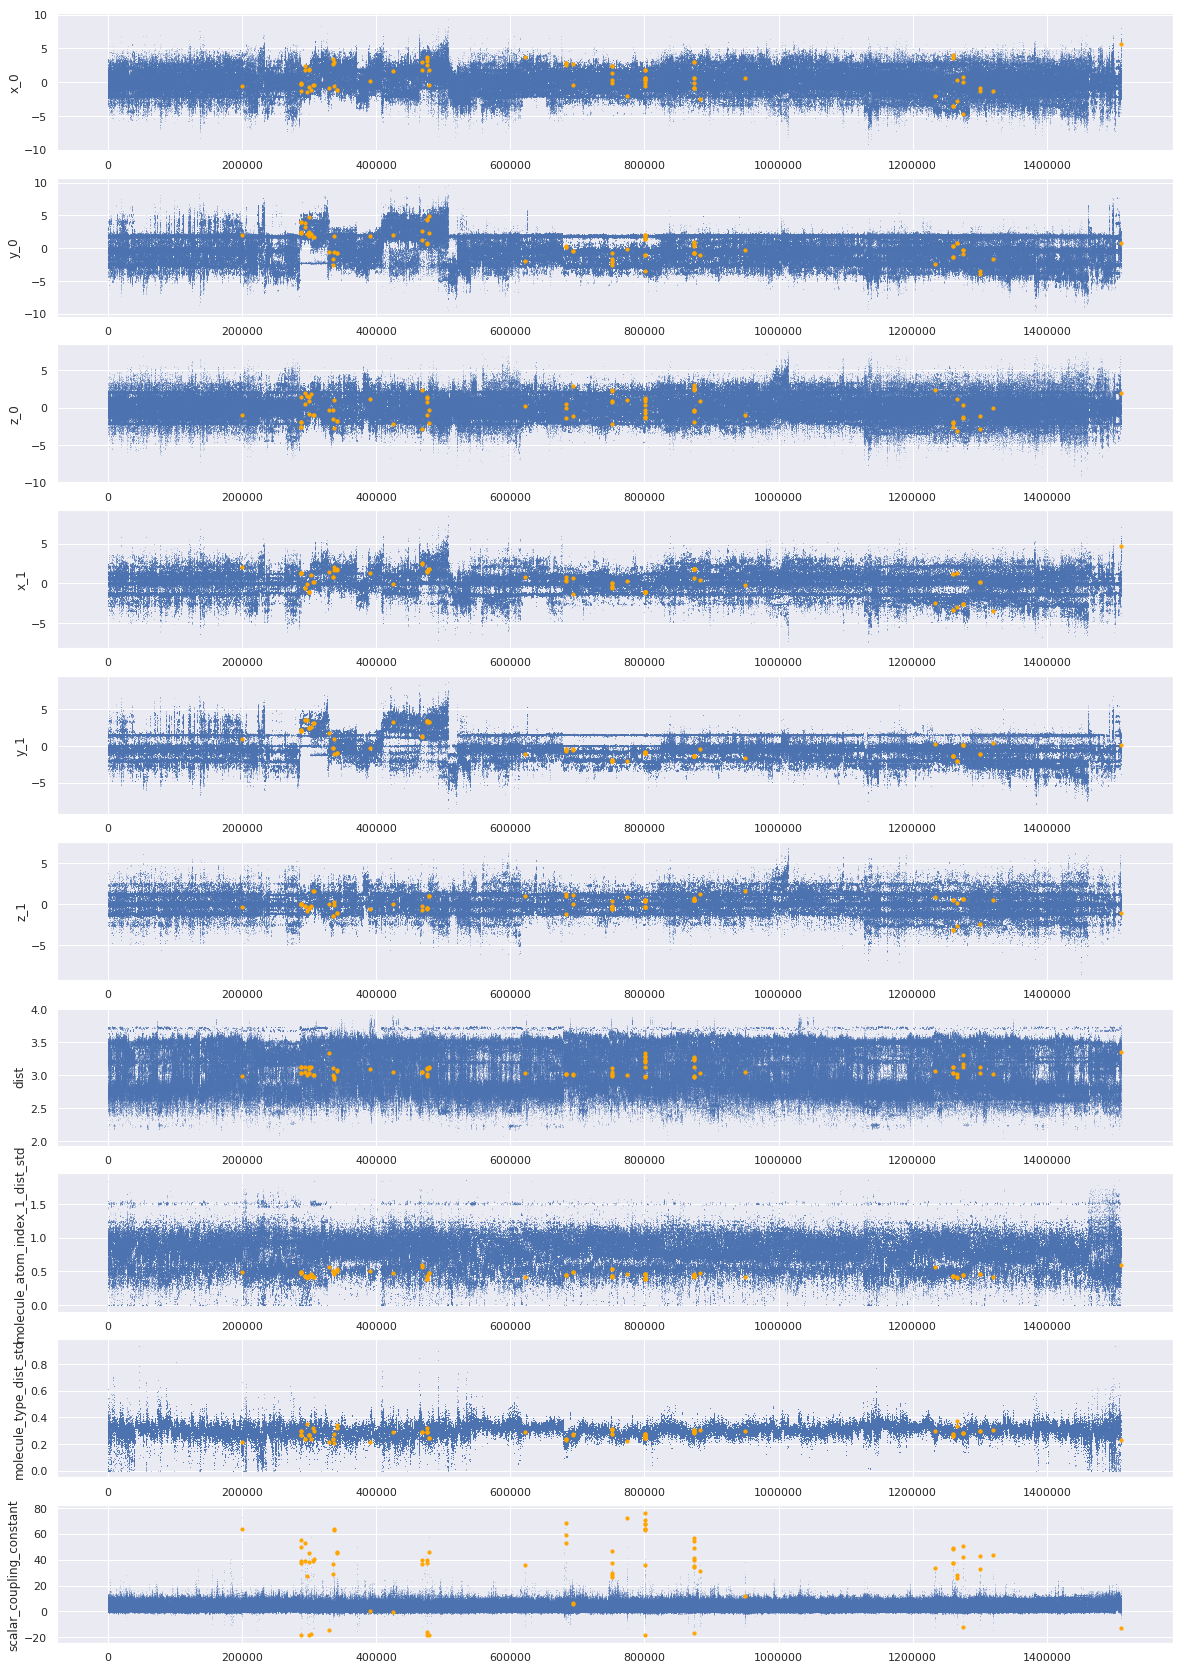

In [110]:
fig, axs = plt.subplots(len(col_list), 1, figsize=(20, 30))
axs = axs.ravel()
for i, col in enumerate(col_list):
    axs[i].scatter(np.arange(len(train.loc[train['type']==ctype, col])), 
                             train.loc[train['type']==ctype, col], lw=0, marker='o', alpha=0.3, s=1)
    axs[i].scatter(np.arange(len(train.loc[train['type']==ctype, col]))[error_idx],
                   train.loc[train['type']==ctype, col][error_idx], color='orange', s=10)
    axs[i].set_ylabel(col)

---> オレンジの点が縦に並んでいるところが確認できる。同じ分子に属していることが考えられる。  
---> つまり、うまく回帰できていない分子が存在する。  
---> y_0, y_1 の特徴量がかなりいびつな形をしている。なんでだろう。  
---> scalar_coupling_constant がの絶対値が大きい値をとっているところがうまく行っていないようだ。

---
**to do**
    - 3JHCを調べることで、scalar_coupling_constantの絶対値が大きいところが、うまく回帰できていないことがわかった。
    - 次は、すべてのtypeで見てみる。